In [1]:
import yaml
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker, scoped_session
import pandas as pd
import mplfinance as mpf

from core import config
from chan import interval_period, get_data, add_bollinger_bands, add_macd, merge_candle, identify_fractal, filter_fractals, filter_fractals, find_centers

In [2]:
symbol = 'GMXUSDT'
interval = '30m'
amount = 200
df = get_data(symbol, interval_period[interval], amount)
df = df[:-1]

# 先将布林带数值计算出来
df = add_bollinger_bands(df)
# 再将MACD数值计算出来
df = add_macd(df)
# 处理K线的包含关系
df_merged = merge_candle(df)
# 判断是否有分型
df_fractal = identify_fractal(df_merged)
# 过滤掉无效的分型
df_filtered = filter_fractals(df_fractal)
# 找出中枢
df_centered = find_centers(df_filtered)

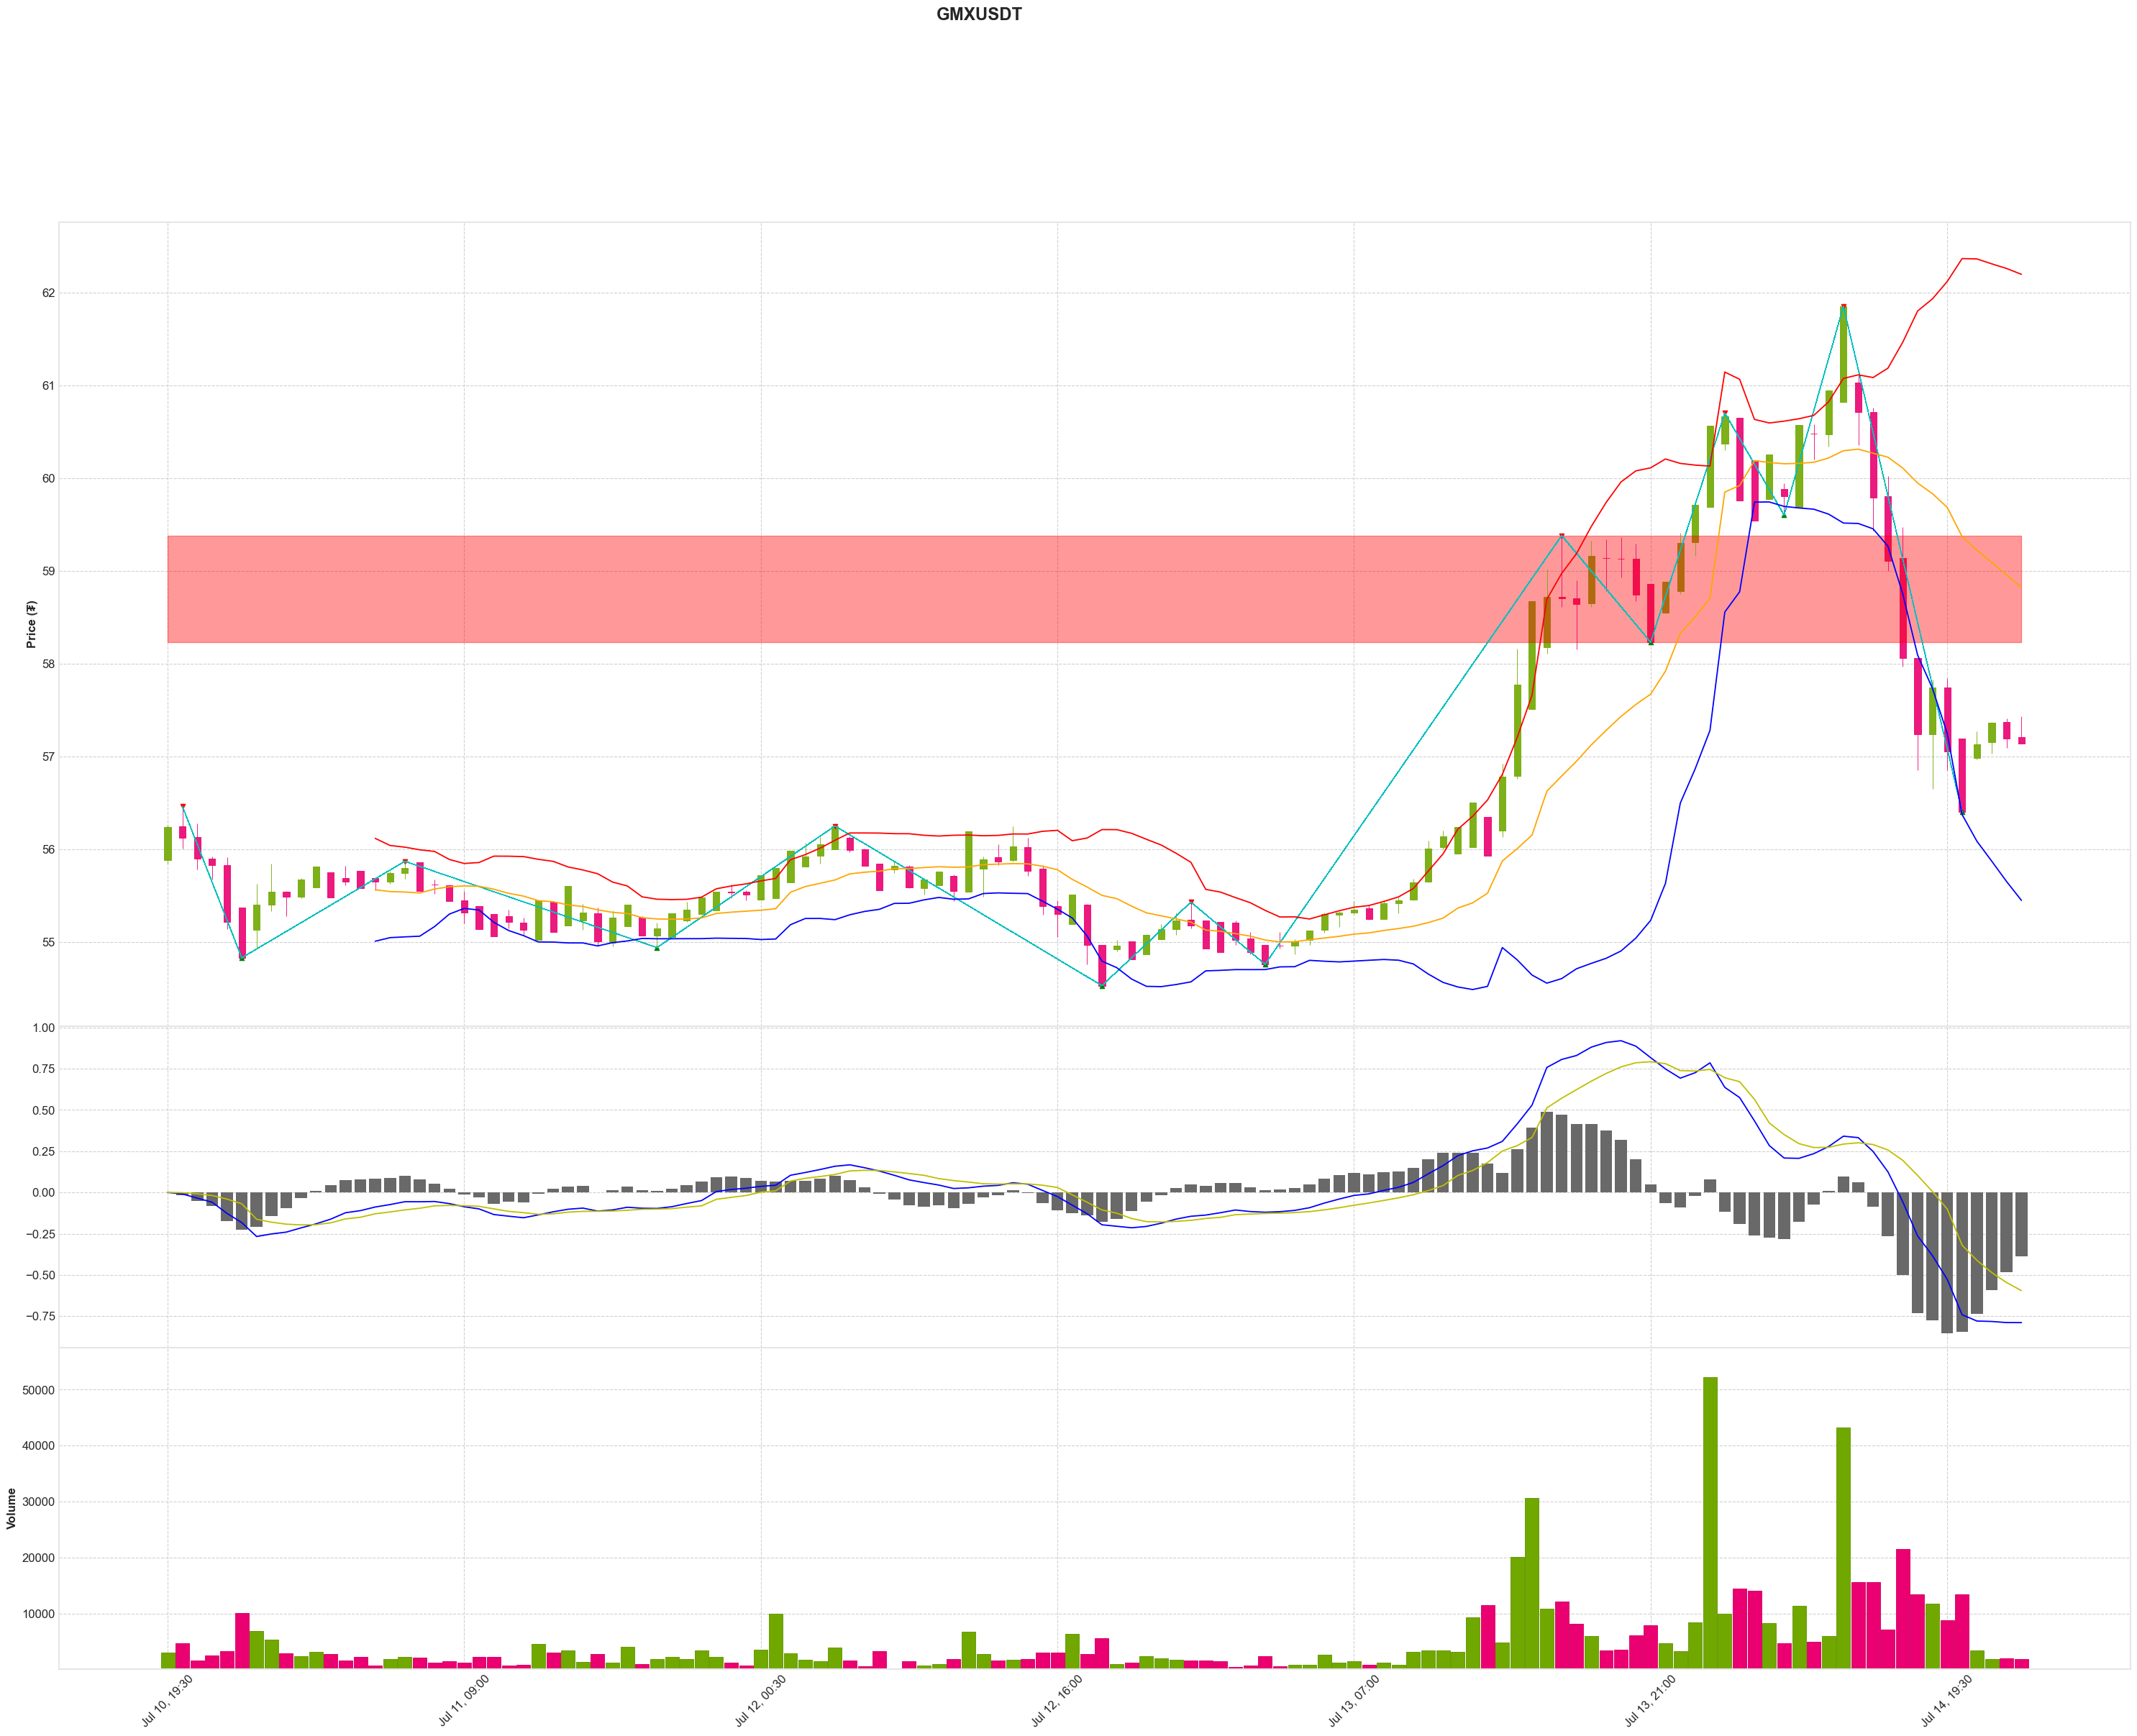

In [3]:
# 创建布林带和 MACD 的附图
ap_mid_band = mpf.make_addplot(df_centered['Middle Band'], panel=0, color='orange') # 将布林带设为面板0
ap_upper_band = mpf.make_addplot(df_centered['Upper Band'], panel=0, color='red')
ap_lower_band = mpf.make_addplot(df_centered['Lower Band'], panel=0, color='blue')
ap_DIF = mpf.make_addplot(df_centered['DIF'], panel=1, color='b', secondary_y=False) # 将MACD设为面板1
ap_DEA = mpf.make_addplot(df_centered['DEA'], panel=1, color='y', secondary_y=False)
ap_MACD = mpf.make_addplot(df_centered['MACD'], panel=1, color='dimgray', secondary_y=False, type='bar')
# 创建两个布尔数组，用于标记顶分型和底分型
tops = (df_centered['fractal'] == 'top')
bottoms = (df_centered['fractal'] == 'bottom')
# 创建两个新的Series，长度与df_identified相同
tops_series = pd.Series(index=df_centered.index)
bottoms_series = pd.Series(index=df_centered.index)
# 对于顶分型和底分型，将价格填入相应的Series
tops_series[tops] = df_centered['High'][tops]
bottoms_series[bottoms] = df_centered['Low'][bottoms]
# 使用make_addplot()来创建额外的绘图，用于标记顶分型和底分型
addplot_tops = mpf.make_addplot(tops_series, scatter=True, markersize=20, marker='v', color='r')
addplot_bottoms = mpf.make_addplot(bottoms_series, scatter=True, markersize=20, marker='^', color='g')

addplot_all = [ap_mid_band, ap_upper_band, ap_lower_band, ap_DIF, ap_DEA, ap_MACD, addplot_tops, addplot_bottoms]

# 创建一个新的DataFrame，只包含有分型的行
df_fractals = df_centered.dropna(subset=['fractal'])
# 初始化一个空列表用于存储分型和对应的价格
fractals_lines = []
# 在df_centered中遍历所有有分型的数据
for idx, row in df_fractals.iterrows():
    # 根据分型类型选择价格
    price = row['High'] if row['fractal'] == 'top' else row['Low']

    # 将日期和价格组成一个元组，并添加到列表中
    fractals_lines.append((idx, price))

all_lines = dict(alines=fractals_lines, colors='c', linewidths=0.5)

# 过滤出'center_type'列不为空的行
df_centered_long = df_centered.loc[df_centered['center_type'] == 'long']
df_centered_short = df_centered.loc[df_centered['center_type'] == 'short']

# 初始化一个空的矩形列表
rectangles_long = []
rectangles_short = []

# 遍历df_centered_long中的所有行，找到所有的中枢
for index, row in df_centered_long.iterrows():
    if row['center'] == 'start':
        if row['fractal'] == 'top':
            y1 = row['High']
        else:
            y1 = row['Low']
    elif row['center'] == 'stop':
        if row['fractal'] == 'top':
            rectangle = dict(y1=y1, y2=row['High'], alpha=0.4, color='g')
        else:
            rectangle = dict(y1=y1, y2=row['Low'], alpha=0.4, color='g')
        rectangles_long.append(rectangle)

# 遍历df_centered_short中的所有行，找到所有的中枢
for index, row in df_centered_short.iterrows():
    if row['center'] == 'start':
        if row['fractal'] == 'top':
            y1 = row['High']
        else:
            y1 = row['Low']
    elif row['center'] == 'stop':
        if row['fractal'] == 'top':
            rectangle = dict(y1=y1, y2=row['High'], alpha=0.4, color='r')
        else:
            rectangle = dict(y1=y1, y2=row['Low'], alpha=0.4, color='r')
        rectangles_short.append(rectangle)

rectangles = rectangles_long + rectangles_short

# 绘制图表
mpf.plot(df_centered, figscale=5, type='candle', style='binance', title=symbol, ylabel='Price (₮)', volume=True, ylabel_lower='Volume', volume_panel=2, addplot=addplot_all, alines=dict(alines=fractals_lines, colors='c', linewidths=0.5), fill_between=rectangles, warn_too_much_data=1000)